In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats

from ADM1_class import ADM1_instance

In [2]:
#some random plot function, which should be able to plot everything I need
def plot(instance, results, t, flag_list = []):
    #possible: biomass, gasses, diluted, all
        solu_index = None
        if(flag_list == 'biomass'):
            solu_index = range(17,27)
        if(flag_list == 'CH4'):
            solu_index = [4]
        
        start_index = len(t) - len(results)
        
        plt.figure()
        plt.title(f'Microbial species presumed to exist on Mars at {instance.T_ad}K.')
        for i in results.keys()[solu_index]:    
            plt.plot(t[start_index:], results.loc[:,i], label = i)
        plt.ylabel("Biomass [gCOD/L]")
        plt.xlabel("time [d]")
        plt.legend()
        
def dilution(instance, data_simulation, data_observation, t_simulation, t_observation):
    #other process producing baseline methane
    #simple dilution using a half sphere to compare the found concentration to the simulated concentration a distance away from the source
    v1 = instance.V_gas 
    c1 = data_simulation['P_ch4'].max() #-  data_simulation['P_ch4'].min() #amplitude of this data
    c1_t = t_simulation[data_simulation[data_simulation['P_ch4'] == data_simulation['P_ch4'].max()].index.values]#time of maximum simulated data
    
    c2 = max(data_observation)# - min(data_observation) #amplitude of this data
    c2_t = t_observation[data_observation.index(max(data_observation))] #index of maximum observed data
    
    r = ((3 * c1 * v1) /( 8* np.pi * c2))**(1/3) #calculate distance based on half dome dilution
    v2 = r**3 * 8/3 * np.pi #volume of second half sphere used to recalculate other gas concentrations
     
    #time shift
    time_shift = abs(c1_t - c2_t) #this calculated the difference in time between the peaks of the observed and measured data
    
    new_data_simulation = data_simulation * (v1/v2) #calculate other gas concentrations
    
    return new_data_simulation, r, time_shift

def Chi_Squared(observed_data_x, observed_data_y, expected_data_x, expected_data_y):
    #observed is from simulation
    observed_data_x = np.array(observed_data_x) 
    observed_data_y = np.array(observed_data_y)
    
    #expected is base truth
    expected_data_x = np.array(expected_data_x) 
    expected_data_y = np.array(expected_data_y)
    
    print()
    
    plt.figure()
    #plt.plot( expected_data_y,  observed_data_y[np.where(expected_data_x == observed_data_x)[0][0]], '.', label = "observed")
    plt.plot( expected_data_x,  expected_data_y, '.', label = "base truth")
    plt.plot( observed_data_x,  observed_data_y, '.', label = "sim truth")
    plt.legend()
    
    
    dof = -1
    chi_squared = 0
    for i in (expected_data_x):
        a = observed_data_y[np.where(observed_data_x == i)[0][0]]
        b = expected_data_y[np.where(expected_data_x == i)[0][0]]
        
        
        dof +=1
        chi_squared += (a - b)**2 / (b)
    p = 1 - stats.chi2.cdf(chi_squared, dof)
    
    return chi_squared, dof, p

In [3]:
mars = ADM1_instance(T_ad = 298.15, V_liq = 3400, V_gas = 300, p_atm = 1.013, q_ad = 0)
solution, gasses, t = mars.dyn_sim(20.0, resolution = 100) #generate results from simulation, [gCOD/L], [Bar], [days]


{ |           }
{ |          }
{ ||         }
{ |||        }
{ ||||       }
{ |||||      }
{ ||||||     }
{ |||||||    }
{ ||||||||   }
{ |||||||||  }


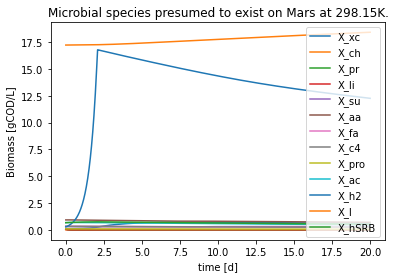

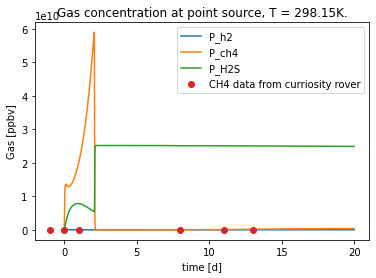

In [4]:
#analyse results from simulation
t_rover = [-1,0, 1, 8, 11, 13]
CH4_observations = [3, 5.78, 15.5, 2.13, 5, 5] #ppbv
Mars_atmosphere = [['Co2', 'N2', 'Ar', 'O2', 'CO', 'P'],[0.951, 0.0259, 0.0194, 0.0016, 0.008]]

plt.figure()
plt.title(f'Microbial species presumed to exist on Mars at {mars.T_ad}K.')
for i in solution.keys()[14:27]:    
    plt.plot(t, solution.loc[:,i], label = i)
plt.ylabel("Biomass [gCOD/L]")
plt.xlabel("time [d]")
plt.legend()
#plt.savefig(f'ADM1_raw_biomass_{T_ad}.png')

P_gasses = ['P_h2', 'P_ch4', 'P_H2S']
advanced_gasses = gasses[P_gasses]
advanced_gasses /= Mars_atmosphere[-1][-1] * 10e-9 #convert to ppbv 

plt.figure()
plt.title(f"Gas concentration at point source, T = {mars.T_ad}K.")
for i in P_gasses:
    plt.plot(t[0:-1], advanced_gasses.loc[:,i], label = i)
    
plt.plot(t_rover, CH4_observations, 'o', label = 'CH4 data from curriosity rover')
plt.ylabel("Gas [ppbv]")
plt.xlabel("time [d]")
plt.legend()
#plt.savefig(f'ADM1_raw_gasses_{T_ad}.png')

ValueError: x and y must have same first dimension, but have shapes (5,) and (6,)

<Figure size 432x288 with 0 Axes>

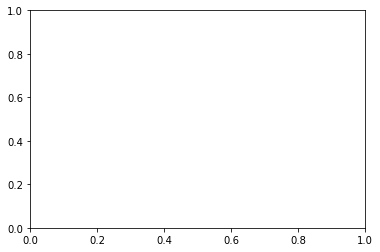

In [5]:
#non fitted data
plt.figure()
chi_value = Chi_Squared(np.array(t.tolist()[:-1]), np.array(gasses['P_ch4'].tolist()), (t_rover[1:]), CH4_observations)
print(chi_value)
#plt.plot(np.array(t.tolist()[:-1]), np.array(gasses['P_ch4'].tolist()), label = 'simulation data')
#plt.plot((t_rover[1:]), CH4_observations[1:], '.', label = 'rover data')
print(1 - stats.chi2.cdf(chi_value[0], chi_value[1]), "p value")

#fitted data
data, r, dt = dilution(mars, gasses, CH4_observations, t, t_rover)

chi_value2 = Chi_Squared(np.array(t.tolist()), np.array(data['P_ch4'].tolist()), (np.array(t_rover) + dt).round(2), CH4_observations)
print(chi_value2)
#plt.plot(np.array(t.tolist()[1:]), np.array(data['P_ch4'].tolist()), label = 'simulation data shifted')
#plt.plot((np.array(t_rover) + dt).round(2), CH4_observations, '.', label = 'rover data shifted')
#plt.legend()
print(1 - stats.chi2.cdf(chi_value2[0], chi_value2[1]), "p value")

p = 0.009179741590992331, r = 0.9207159985019837, rmse = 5.639494497803398
p 2.946445834704839e-06, r0.998598138543539, rmse5.179308591315395


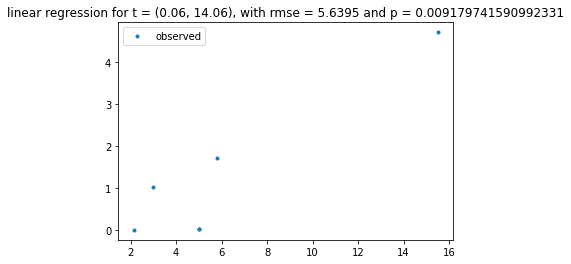

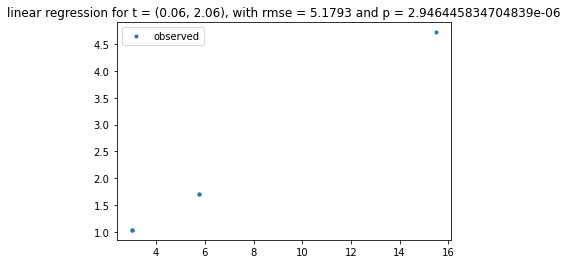

In [5]:
import scipy.stats as sp

def Statistics(observed_data_x, observed_data_y, expected_data_x, expected_data_y, t_0 = 0, t_n = -1):
#observed is from simulation
    observed_data_x = np.array(observed_data_x) 
    observed_data_y = np.array(observed_data_y)

#expected is base truth
    expected_data_x = np.array(expected_data_x) 
    expected_data_y = np.array(expected_data_y)
    
#allow time-piecewise analysis
    t_0 = np.where(expected_data_x >= t_0)
    t0 = t_0[0][0]
    
    if t_n > 0:
        t_n = np.where(expected_data_x <= t_n)
        tn = t_n[0][-1]
    else:
        tn = len(expected_data_x) -1
    
#make and fill conatiners for timed indexes for: t_expected == t_observed
    observed_t_i = []
    expected_t_i = []

    for i in np.linspace(t0, tn, len(expected_data_x), dtype = int):
        d = np.where(observed_data_x == expected_data_x[i])
        expected_t_i.append(d[0][0])
        
        f = np.where(expected_data_x == observed_data_x[d[0][0]])
        observed_t_i.append(f[0][0])       
    

#Pearsons R and two tailed p, calculation
    r = sp.stats.pearsonr(expected_data_y[observed_t_i], observed_data_y[expected_t_i])

#RMSE calculation
    se = (expected_data_y[observed_t_i] - observed_data_y[expected_t_i])**2
    mse = se.sum() / len(observed_t_i)
    rmse = mse**0.5
    
    plt.figure()
    plt.title(f"linear regression for t = {expected_data_x[t0],expected_data_x[tn]}, with rmse = {rmse.round(4)} and p = {r[1]}")
    plt.plot(expected_data_y[observed_t_i],  observed_data_y[expected_t_i], '.', label = "observed")
    plt.legend()
    
#returns two-tailed p-value, pearsons correlation coeficient, rmse value between the data
    return r[1],  r[0], rmse

data, r, dt = dilution(mars, gasses, CH4_observations, t, t_rover)
f1 = Statistics(np.array(t.tolist())[:-1], np.array(gasses['P_ch4'].tolist()), (np.array(t_rover) + dt).round(2), CH4_observations, 0 , 15)
print(f'p = {f1[0]}, r = {f1[1]}, rmse = {f1[2]}')

f2 = Statistics(np.array(t.tolist())[:-1], np.array(gasses['P_ch4'].tolist()), (np.array(t_rover) + dt).round(2), CH4_observations, 0, 3)
print(f'p {f2[0]}, r{f2[1]}, rmse{f2[2]}')